# Домашнее задание 7


**Обучить нейронную сеть для распознавания действий человека по видео на датасете KTH**
**Библиотеки: [Python, Tensorflow]**

## Переключение версии TensorFlow

In [1]:
%tensorflow_version 2.x

In [2]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [3]:
if 1:
    !pip install scikit-video==1.1.11
import skvideo.io

## Загрузка и распаковка датасета KTH

In [4]:
if 0:
    !wget http://www.nada.kth.se/cvap/actions/walking.zip
    !wget http://www.nada.kth.se/cvap/actions/jogging.zip
    !wget http://www.nada.kth.se/cvap/actions/running.zip
    !wget http://www.nada.kth.se/cvap/actions/boxing.zip
    !wget http://www.nada.kth.se/cvap/actions/handwaving.zip
    !wget http://www.nada.kth.se/cvap/actions/handclapping.zip 

if 0:
    !unzip walking.zip -d walking > /dev/null
    !unzip jogging.zip -d jogging > /dev/null
    !unzip running.zip -d running > /dev/null
    !unzip boxing.zip -d boxing > /dev/null
    !unzip handwaving.zip -d handwaving > /dev/null
    !unzip handclapping.zip -d handclapping > /dev/null

## Подготовка датасета для классификации

In [5]:
classes = [
    'walking',
    'jogging',
    'running',
    'boxing',
    'handwaving',
    'handclapping',
]

dataset = []
data_root = './'
for cls in classes:
    print('Processing class: {}'.format(cls))
    for fpath in glob.glob(os.path.join(data_root, cls, '*.avi')):
        cls_idx = classes.index(cls)
        dataset.append((fpath, cls_idx))

Processing class: walking
Processing class: jogging
Processing class: running
Processing class: boxing
Processing class: handwaving
Processing class: handclapping


In [6]:
SUBSET_LEN = 180
random.shuffle(dataset)
dataset = dataset[:SUBSET_LEN]

print('Dataset samples (subset):', len(dataset))

Dataset samples (subset): 180


## Визуализация кадра из видео

videodata shape: (425, 120, 160, 3)


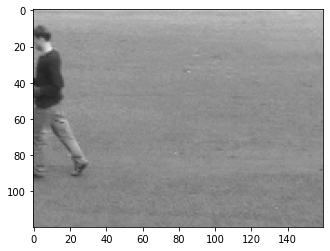

In [7]:
videodata = skvideo.io.vread(dataset[0][0])
videodata = videodata.astype(np.float32) / 255.
print('videodata shape:', videodata.shape)
plt.imshow(videodata[40, ...])

## Визуализация "движения"

motion shape: (424, 120, 160, 1)


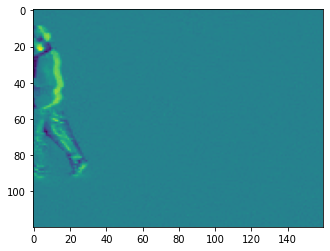

In [8]:
motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
print('motion shape:', motion.shape)
plt.imshow(motion[40, ..., 0])

## Создание модели CNN

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(32, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same', activation=None),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation=None),
])

## Посмотрим описание модели

In [10]:
inp = motion[None, ...]
out = model(inp)

print('Input shape:', inp.shape)
print('Output shape:', out.shape)

Input shape: (1, 424, 120, 160, 1)
Output shape: (1, 6)


In [11]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (1, 424, 60, 80, 32)      4032      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (1, 424, 30, 40, 32)      0         
_________________________________________________________________
conv3d_1 (Conv3D)            (1, 424, 15, 20, 64)      256064    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (1, 424, 8, 10, 64)       0         
_________________________________________________________________
conv3d_2 (Conv3D)            (1, 424, 4, 5, 64)        110656    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (1, 424, 2, 3, 64)        0         
_________________________________________________________________
conv3d_3 (Conv3D)            (1, 424, 2, 3, 64)        1

## Отобразим модель графически

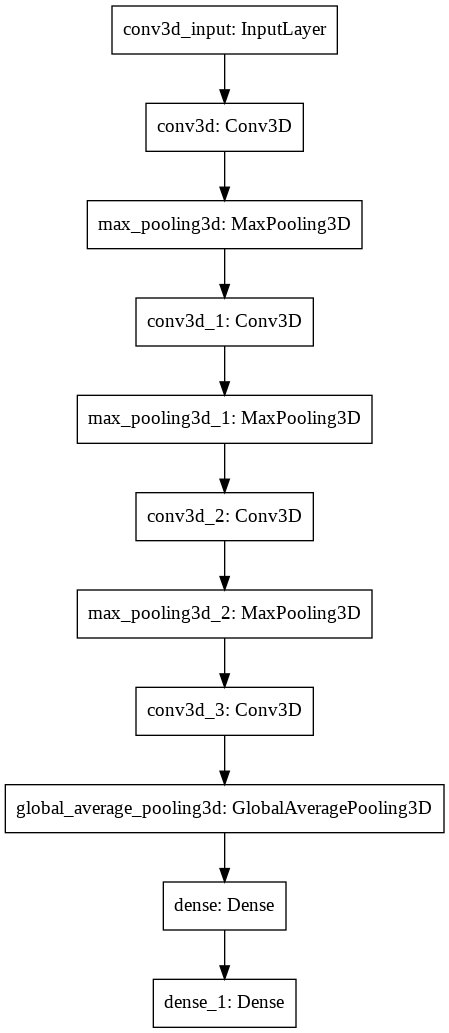

In [12]:
tf.keras.utils.plot_model(model)

## Подготовка к обучению

In [13]:
NUM_EPOCHS = 12
LEARNING_RATE = 0.001

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE))

writer = tf.summary.create_file_writer('logs/exp1')

## Тренировка модели

In [14]:
%%time

global_step = 0
for ep in range(NUM_EPOCHS):
    for iter, (fpath, label) in enumerate(dataset):
        videodata = skvideo.io.vread(fpath)
        videodata = videodata.astype(np.float32) / 255.
        motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
        x = motion[None, ...]
        y = np.array(label)[None, ...]

        loss_value = model.train_on_batch(x, y)

        if iter % 10 == 0:
            print(f'[{ep}/{NUM_EPOCHS}][{iter}/{len(dataset)}] Loss = {loss_value}')

            with writer.as_default():
                tf.summary.scalar('loss', loss_value, global_step)

        global_step += 1

[0/12][0/180] Loss = 1.7915306091308594
[0/12][10/180] Loss = 1.7366585731506348
[0/12][20/180] Loss = 1.7692091464996338
[0/12][30/180] Loss = 1.909067153930664
[0/12][40/180] Loss = 1.733782172203064
[0/12][50/180] Loss = 1.6823735237121582
[0/12][60/180] Loss = 1.4271583557128906
[0/12][70/180] Loss = 2.35003399848938
[0/12][80/180] Loss = 1.927072286605835
[0/12][90/180] Loss = 1.783844232559204
[0/12][100/180] Loss = 1.8517390489578247
[0/12][110/180] Loss = 1.7274742126464844
[0/12][120/180] Loss = 1.1956613063812256
[0/12][130/180] Loss = 1.8242331743240356
[0/12][140/180] Loss = 1.5876274108886719
[0/12][150/180] Loss = 1.612057089805603
[0/12][160/180] Loss = 1.5222232341766357
[0/12][170/180] Loss = 0.7742101550102234
[1/12][0/180] Loss = 0.7824182510375977
[1/12][10/180] Loss = 1.3104242086410522
[1/12][20/180] Loss = 0.8423925638198853
[1/12][30/180] Loss = 1.6393988132476807
[1/12][40/180] Loss = 1.5352263450622559
[1/12][50/180] Loss = 0.5140101909637451
[1/12][60/180] Lo

## TensorBoard

In [15]:
%load_ext tensorboard
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 15106), started 1:33:19 ago. (Use '!kill 15106' to kill it.)

<IPython.core.display.Javascript object>

## Проверка модели на тестовых данных

In [16]:
def my_test():
    fpath, cls_true = random.choice(dataset)

    videodata = skvideo.io.vread(fpath)
    videodata = videodata.astype(np.float32) / 255.
    plt.imshow(videodata[30, ...])

    motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)

    out = model(motion[None, ...])[0]
    cls_pred = np.argmax(out.numpy())

    print('True class:', classes[cls_true])
    print('Predicted class:', classes[cls_pred])

**Первый тест**

True class: handwaving
Predicted class: handwaving


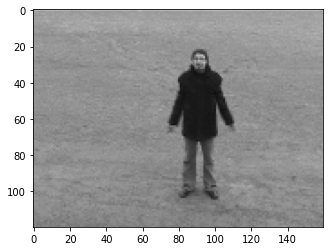

In [17]:
my_test()

**Второй тест**

True class: walking
Predicted class: jogging


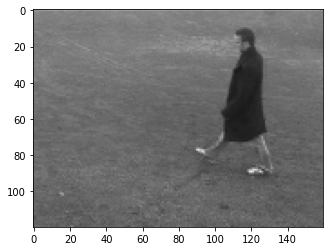

In [18]:
my_test()

**Третий тест**

True class: handclapping
Predicted class: handclapping


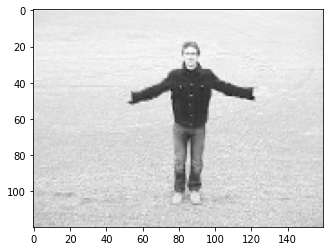

In [19]:
my_test()

**Четвертый тест**

True class: handwaving
Predicted class: handwaving


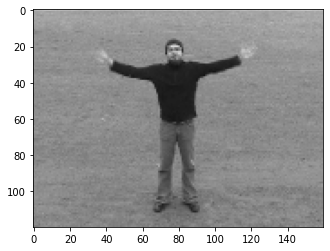

In [20]:
my_test()

**Пятый тест**

True class: jogging
Predicted class: jogging


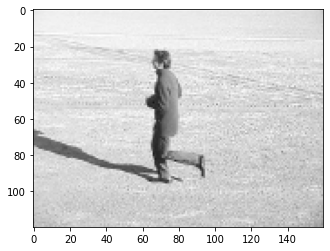

In [21]:
my_test()

**Шестой тест**

True class: boxing
Predicted class: boxing


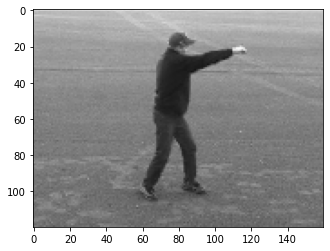

In [22]:
my_test()

**Седьмой тест**

True class: handclapping
Predicted class: handclapping


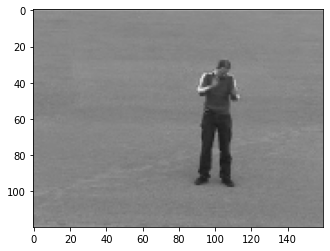

In [23]:
my_test()

**Выводы:** 
- тесты показали, что полученные результаты достаточно достоверны, учитывая примитивность модели, датасета и алгоритмов;
- в дальнейшем можно переработать алгоритм, добавить в него батчи, валидационный датасет, поиграться с моделью сети, увеличить число итераций и убедиться в отсутствии/минимизации переобучения;
- задание выполнено полностью. Полученные результаты верны.